In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import os
# Parametros estéticos do matplotlib
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format
                
def create_folder(folder_name, path = os.getcwd()):
    '''
    Função que cria uma pasta em um determinado diretório. Criada com o objetivo de
    ser usada junto com as funções de plotagem para salvar as figuras
    
    Parameters
    ----------
    folder_name: str
        nome da pasta a ser criada
    path: str (default=os.getcwd(), diretório de trabalho atual)
        diretório onde a pasta será criada    
    '''
    try:
        PATH = os.path.join(path, str(folder_name))
        os.mkdir(PATH)
        print("Folder", "{}".format(folder_name), "criado")
        return PATH
    except FileExistsError:
        return PATH
    except TypeError:
        print("TypeError between path ({}) and folder_name ({})".format(path, folder_name))
    
matplotlib.rcParams["savefig.directory"] = os.chdir(create_folder('Figures'))

In [250]:
def gera_grid(dx, l, h):
    '''
    Função que cria, a partir das dimensões do espaço `l` e `h` e a partir da
    discretização deste espaço `dx` (=`dy`) um grid que o descreve
    
    Parameters
    ----------
    dx: float
        passo
    l: float
        largura do grid
    h: float
        altura do grid

    Returns
    -------
    M: int
        tamanho da grade em x
    N: int
        tamanho da grade em y
    X: np.ndarray, dim=(N, M)
        meshgrid em x
    Y: np.ndarray, dim=(N, M)
        meshgrid em y
    grid: np.ndarray, dim=(N, M)
        grid do sistema, inicialmente em branco
    '''
    # dimensões do grid
    M = int(l/dx) + 1
    N = int(h/dx) + 1

    # inicializando o grid
    grid = np.zeros((N, M))

    # criando dois vetores lineares x e y e os usando de base
    # para as matrizes X e Y, resultantes do meshgrid
    x = np.linspace(0, l, M)
    y = np.linspace(-h/2, h/2, N)
    X, Y = np.meshgrid(x, y)
    X = np.around(X, decimals=5)
    Y = np.around(Y, decimals=5)


    return M, N, X, Y, grid

def define_elementos(X_, Y_, grid):
    '''
    Função que toma o `grid`, gerado pelo método `gera_grid()` e o completa
    com a identificação dos elementos que o compõe cada qual em sua posição

    Parameters
    ----------
    X_: np.ndarray, dim=(N, M)
        meshgrid em x
    Y_: np.ndarray, dim=(N, M)
        meshgrid em y
    grid: np.ndarray, dim=(N, M)
        grid do sistema, inicialmente em branco

    Notes
    -----
    Para tornar o EP mais dinâmico e eficiente, decidiu-se criar apenas um
    grid composto por elementos infinitesimais que indicam o meio ao qual
    pertencem. Para tanto, utilizou-se a seguinte notação:
    - 0: pontos que não fazem parte do grid (resto que fica acima e abaixo
         da parte à direita da bobina, para preencher o espaço retangular)
    - 1: entreferro
    - 2: armadura
    - 3: núcleo de ferro
    - 4: bobina_LE
    - 5: bobina_LD
    Com este método, todas as grandezas que dependem do meio podem facilmente
    ser definidas e, apenas com uma matriz, é possível descrever por exemplo
    a corrente Jz em todo o sistema (podemos filtrar os pontos em que temos
    a bobina e tornar todo o resto da matriz 0)
    '''
    X = 100*X_
    Y = 100*Y_
    # definindo as regiões dos diferentes elementos
    armadura = (X <= 4)
    entreferro = np.logical_or(
        # primeiro retângulo, 
        # -10 <  y <  10
        #   4 <  X <   5
        np.logical_and(X > 4, X < 5),
        # região do meio,
        #  -6 <  y <   6
        #   5 <= x <  14
        np.logical_and(
            np.logical_and(X >= 5, X < 14),
            np.logical_and(Y > -6, Y < 6)
            )
        )

    nucleo = np.logical_or(
        # pontas
        # y <= -6 | y >= 6
        # 5 <= x <  20
        np.logical_and(
            np.logical_and(X >= 5, X <= 20),
            np.logical_or(Y <= -6, Y >= 6)
            ),
        # barra vertical (entre as bobinas)
        # -10 <  y <  10
        #  16 <  x <  16
        np.logical_and(X > 16, X < 20)
        )

    bobina_LE =  np.logical_and(
        # bobina da esquerda (corrente entrando na folha)
        #  -6 <= y <=  6
        #  14 <= x <  16
        np.logical_and(X >= 14, X <= 16),
        np.logical_and(Y > -6, Y <  6)
        )
    
    bobina_LD = np.logical_and(
        # bobina da direita (corrente saindo da folha)
        #  -6 <= y <=  6
        #  20 <= x <  22
        np.logical_and(X >= 20, X <= 22),
        np.logical_and(Y > -6, Y <  6)
        )
        

    # assignando os códigos de cada região (regiões não assignadas não fazem
    # parte do sistema, região externa, continuam em 0)
    grid[entreferro]    = 1
    grid[armadura]      = 2
    grid[nucleo]        = 3
    grid[bobina_LE]     = 4
    grid[bobina_LD]     = 5
    
    return grid

def gera_mu(grid, urAr, urFex, urFey):
    '''
    Método que gera uma matriz com o valor das permeabilidades
    para cada elemento do grid

    Parameters
    ----------
    grid: np.ndarray, dim=(N, M)
        grid do sistema, contém as identificações dos elementos
    urAr: float
        permeabilidade magnética do ar
    urFex: float
        permeabilidade magnética do ferro na direção x
    urFey: float
        permeabilidade magnética do ferro na direção y

    Returns
    -------
    mu: np.ndarray, dim=(N, M, 2)
        valores da permeabilidade (mu) em cada meio, com o primeiro eixo
        sendo x e o segundo sendo y
    '''
    mu = np.dstack((np.piecewise(grid, 
        [
        grid==0,  #vazios      - mu_Ar
        grid==1,  #entreferro  - mu_Ar
        grid==2,  #armadura    - mu_Fex
        grid==3,  #nucleoFerro - mu_Fex
        grid==4,  #bobinaLE    - mu_Ar
        grid==5   #bobinaLD    - mu_Ar
        ], 
        [urAr, urAr, urFex, urFex, urAr, urAr]
    ), 
    np.piecewise(grid, 
        [
        grid==0,  #vazios      - mu_Ar
        grid==1,  #entreferro  - mu_Ar
        grid==2,  #armadura    - mu_Fey
        grid==3,  #nucleoFerro - mu_Fey
        grid==4,  #bobinaLE    - mu_Ar
        grid==5   #bobinaLD    - mu_Ar
        ], 
        [urAr, urAr, urFey, urFey, urAr, urAr]
    )))
    
    return mu

def inicializa_matriz_A(dx, l, h):
    '''
    Função que inicializa a matriz A, dos potenciais eletromagnéticos
    
    Parameters
    ----------
    dx: float
        passo
    l: float
        largura do grid
    h: float
        altura do grid
    '''
    _, _, _, _, A = gera_grid(dx, l, h)
    
    return A

def aplica_cc(A, grid):
    '''
    Função que aplica as condições de contorno em A, o que inclui
    as condições de Dirichlet (potencial na fronteira externa constante
    e igual a 0) e também zera o potencial para os pontos do grid que
    "não pertencem" ao problema (pontos que foram anexados para tornar)
    o grid regular, mas que não fazem parte do problema
    '''
    # bordas com potencial nulo
    A[ 0,  :] = 0
    A[-1,  :] = 0
    A[ :,  0] = 0
    A[ :, -1] = 0
    # zera partes que não pertencem ao problema
    A         = np.where(grid==0, 0, A)
    
    return A

def gera_matriz_uJ(mu, X, Y, grid, transiente=False, dt=1, k=1, omega=60):
    '''
    Função que gera a matriz de correntes, J, que é nula em todo
    o espaço, exceto dentro da bobina
    
    Parameters
    ----------
    mu: np.ndarray, dim=(N, M, 2)
        valores da permeabilidade (mu) em cada meio
    X: np.ndarray, dim=(N, M)
        meshgrid em x
    Y: np.ndarray, dim=(N, M)
        meshgrid em y
    grid: np.ndarray, dim=(N, M)
        grid do sistema, inicialmente em branco
    transiente: bool (default=False)
        booleano de controle para saber se deve ser adicionado o termo
        transiente
    dt: int (default=1)
        discretização do tempo
    k: int (default=1)
        passo no tempo atual
    omega: float (default=60)
        valor da frequência da rede elétrica
        
    Returns
    -------
    uJ: np.ndarray, dim=(N, M)
    '''
    def calcula_J(y):
        '''
        Função auxiliar que calcula a corrente dado um ponto y
        '''
        return (2e6*np.cos(np.pi*y/12e-2) + 8e5)
    
    J  = np.where(grid==4, -calcula_J(Y), 0) + np.where(grid==5, calcula_J(Y), 0)
    if transiente:
        uJ = J * np.cos(omega*k*dt)
        
    else:
        uJ = np.multiply(J, mu[:, :, 0])

    
    return uJ

def calcula_A(A, dx, M, N, grid, uJ, mu):
    '''
    Função que calcula o potencial eletromagnético para
    todos os pontos do grid
    
    Parameters
    ----------
    A: np.ndarray, dim=(N, M)
        matriz de potenciais eletromagnéticos da iteração anteiror
    dx: float
        discretização da malha
    M: int
        dimensão da matriz A em x
    N: int
        dimensão da matriz B em x
    grid: np.ndarray, dim=(N, M)
        matriz que contém a identificação dos elementos
    uJ: np.ndarray, dim=(N, M)
        matriz com os termos forçantes (correntes) multiplicados por mu
    mu: np.ndarray, dim=(N, M, 2)
        valores da permeabilidade (mu) em cada meio
    
    Returns
    -------
    Anew: np.ndarray, dim=(N, M)
        matriz de potenciais atualizada
    '''
    Anew = A.copy()
    # para cada linha
    for j in range(1, N-1):
        # para cada coluna
        for i in range(1, M-1):
            uC = mu[j + 1,     i, 1]
            uB = mu[j - 1,     i, 1]
            uE = mu[    j, i - 1, 0]
            uD = mu[    j, i + 1, 0]
            
            
            Anew[j, i] = 1/2 * (A[j+1, i]*(uB/(uC + uB)) + A[j-1, i]*(uC/(uC + uB)) 
                              + A[j, i+1]*(uE/(uD + uE)) + A[j, i-1]*(uD/(uD + uE))
                              + dx**2/2 * uJ[j, i])
    aplica_cc(Anew, grid)
    return Anew


def calcula_A_e1(A, dx, M, N, grid, uJ, mu):
    '''
    Função que calcula o potencial eletromagnético para
    todos os pontos do grid
    
    Parameters
    ----------
    A: np.ndarray, dim=(N, M)
        matriz de potenciais eletromagnéticos da iteração anteiror
    dx: float
        discretização da malha
    M: int
        dimensão da matriz A em x
    N: int
        dimensão da matriz B em x
    grid: np.ndarray, dim=(N, M)
        matriz que contém a identificação dos elementos
    uJ: np.ndarray, dim=(N, M)
        matriz com os termos forçantes (correntes) NÃO multiplicado
        pelos mus
    mu: np.ndarray, dim=(N, M, 2)
        valores da permeabilidade (mu) em cada meio
    
    Returns
    -------
    Anew: np.ndarray, dim=(N, M)
        matriz de potenciais atualizada
    '''
    Anew = A.copy()
    # para cada linha
    for j in range(1, N-1):
        # para cada coluna
        for i in range(1, M-1):
            uC = mu[j + 1,     i, 1]
            uB = mu[j - 1,     i, 1]
            uE = mu[    j, i - 1, 0]
            uD = mu[    j, i + 1, 0]
            ux = mu[    j,     i, 0]
            uy = mu[    j,     i, 1]
            
            
            Anew[j, i] = 1/(ux + uy)*(ux*uE/(uE + uD)*A[j, i+1] + ux*uD/(uE + uD)*A[j, i-1]
                                    + uy*uB/(uB + uC)*A[j+1, i] + uy*uC/(uB + uC)*A[j-1, i]
                                    + ux*uy*dx**2*uJ[j, i]/2)
    aplica_cc(Anew, grid)
    return Anew

def calcula_A_transiente(A, dx, M, N, grid, uJ, mu):
    '''
    Função que calcula o potencial eletromagnético para
    todos os pontos do grid
    
    Parameters
    ----------
    A: np.ndarray, dim=(N, M)
        matriz de potenciais eletromagnéticos da iteração anteiror
    dx: float
        discretização da malha
    M: int
        dimensão da matriz A em x
    N: int
        dimensão da matriz B em x
    grid: np.ndarray, dim=(N, M)
        matriz que contém a identificação dos elementos
    uJ: np.ndarray, dim=(N, M)
        matriz com os termos forçantes (correntes) NÃO multiplicado
        pelos mus
    mu: np.ndarray, dim=(N, M, 2)
        valores da permeabilidade (mu) em cada meio
    
    Returns
    -------
    Anew: np.ndarray, dim=(N, M)
        matriz de potenciais atualizada
    '''
    Anew = A.copy()
    # para cada linha
    for j in range(1, N-1):
        # para cada coluna
        for i in range(1, M-1):
            uC = mu[j + 1,     i, 1]
            uB = mu[j - 1,     i, 1]
            uE = mu[    j, i - 1, 0]
            uD = mu[    j, i + 1, 0]
            ux = mu[    j,     i, 0]
            uy = mu[    j,     i, 1]
            
            # se estiver na bobina
            if grid[j, i] in [4, 5]:
                Anew[j, i] = 1/alfa * (ux*uE/(uE + uD)*A[j, i+1] + ux*uD/(uE + uD)*A[j, i-1]
                                     + uy*uB/(uB + uC)*A[j+1, i] + uy*uC/(uB + uC)*A[j-1, i]
                                     + (alfa - ux - uy)*A[j, i] + ux*uy*dx**2*uJ[j, i]/2)
            else:
                Anew[j, i] = 1/(ux + uy)*(ux*uE/(uE + uD)*A[j, i+1] + ux*uD/(uE + uD)*A[j, i-1]
                                        + uy*uB/(uB + uC)*A[j+1, i] + uy*uC/(uB + uC)*A[j-1, i])
    aplica_cc(Anew, grid)
    return Anew

            
def sobrerrelaxa(dx, l, h, iterative_func=calcula_A, max_iter=1e5):
    '''
    Função que aplica a sobrerrelaxação usando com um determinado passo
    usando um determinado lambda até uma determinada tolerância
    
    Parameters
    ----------
    dx: float
        passo
    l: float
        largura do grid
    h: float
        altura do grid
    iterative_func: callable (default=calcula_A)
        função iterativa pra 
    max_iter: float (default=1e5)
        máximo de iterações que se deve fazer
    '''
    M, N, X, Y, grid = gera_grid(dx, l, h)
    A    = inicializa_matriz_A(dx, l, h)
    grid = define_elementos(X, Y, grid)
    mu   = gera_mu(grid, urAr, urFex, urFey)
    
    uJ_parameters = {calcula_A:    {'mu':mu, 'X':X, 'Y': Y, 'grid': grid},
                     calcula_A_e1: {'mu':mu, 'X':X, 'Y': Y, 'grid': grid,
                                    'transiente':True, 'dt':1, 'k':1, 'omega':0}
                    }[iterative_func]
    uJ   = gera_matriz_uJ(**uJ_parameters)
    Anew = iterative_func(A, dx, M, N, grid, uJ, mu)
    erro = np.max(np.abs(np.divide(Anew - A, Anew, out=np.zeros_like(Anew), where=Anew!=0)))
    i = 0
    # erros=np.array([erro])
    print("Iniciando sobrerrelaxação")
    while erro > tol and i < max_iter:
        Anew, A = lbd*iterative_func(Anew, dx, M, N, grid, uJ, mu) + (1 - lbd)*A, Anew
        erro    = np.max(np.abs(np.divide(Anew - A, Anew, out=np.zeros_like(Anew), where=Anew!=0)))
        # erros = np.insert(erros, 0, erro)
        i+= 1
        if i%5e3== 0: 
            print(f"i={i}, erro={erro:.1e}")
    print(f"i={i}, erro={erro:.1e}")
    return Anew

def calcula_B(A, N, M, dx, mu):
    """
    Calcula o vetor B ponto a ponto e retorna um array que são as
    componentes em x e outro que são as componentes em y.
    
    Parameters
    ----------
    A: np.ndarray, dim=(N, M)
        valores de Az
    N: int
        tamanho da grade em y
    M: int
        tamanho da grade em x
    dx: float
        discretização da malha
    mu: np.ndarray, dim=(N, M, 2)
        valores da permeabilidade (mu) em cada meio
    
    Returns
    -------
    Bx: np.ndarray, dim=(N, M)
        matriz das componentes de Bx
    By: np.ndarray, dim=(N, M)
        matriz das componentes de By
    """
    Bx = np.zeros_like(A)
    By = np.zeros_like(A)
    for j in range(1, N-1):
        for i in range(1, M-1):
            uC = mu[j + 1,     i, 1]
            uB = mu[j - 1,     i, 1]
            uE = mu[    j, i - 1, 0]
            uD = mu[    j, i + 1, 0]
            
            delA_delx = (A[j, i+1] - A[j, i-1])/(2*dx)
            delA_dely = (A[j+1, i] - A[j-1, i])/(2*dx)

            Bx[j, i] =   delA_dely
            By[j, i] = - delA_delx
    
    return Bx, By

def calcula_H(B, mu):
    """
    Função que calcula o vetor H, ou a componente relativa do vetor,
    a partir de um vetor B, ou de uma componente do vetor, e do vetor de mus
     Parameters
    ----------
    B: np.ndarray, dim=(N, M)
        matriz das componentes de B
    mu: np.ndarray, dim=(N, M)
        valores da permeabilidade (mu) em cada meio
    
    Returns
    -------
    H: np.ndarray, dim=(N, M)
        valores da componente de H
        
    Notes
    -----
    Na hora de chamar colocar o mu[:, :, 0] para Bx e mu[:, :, 1] para By
    """
    H = np.divide(B, mu)
    return H

def calcula_F(Bx, By, grid, dx):
    """
    Função que calcula as forças nas direções x e y para a armadura.
    Ela é dada pela integral de linha seguindo o contorno na armadura, que 
    neste caso foi discretizada em 4 partes.
    
    Parameters
    ----------
    Bx: np.ndarray, dim=(N, M)
        matriz das componentes de Bx
    By: np.ndarray, dim=(N, M)
        matriz das componentes de By
    grid: np.ndarray, dim=(N, M)
        grid do sistema, com os elementos definidos
    dx: float
        discretização
        
    Returns
    -------
    Fela_x: float
        valor da componente x da força resultante do campo B
    Fela_y: float
        valor da componente y da força resultante do campo B
    """
    max_y, max_x = max(np.where(grid == 2)[0]), max(np.where(grid == 2)[1])
    min_y, min_x = min(np.where(grid == 2)[0]), min(np.where(grid == 2)[1])
    
    Bx2_By2 = Bx**2 - By**2
    
    BxBy = 2*np.multiply(Bx, By)
    
    Fela_x = 1/(2*u0) * (
          np.trapz(Bx2_By2[min_y:max_y,       max_x], dx=dx)
        - np.trapz(   BxBy[      max_y, min_x:max_x], dx=dx)
        - np.trapz(Bx2_By2[min_y:max_y,       min_x], dx=dx)
        + np.trapz(   BxBy[      min_y, min_x:max_x], dx=dx)
    )
    
    Fela_y = 1/(2*u0) * (
              np.trapz(   BxBy[min_y:max_y,       max_x], dx=dx)
            + np.trapz(Bx2_By2[      max_y, min_x:max_x], dx=dx)
            - np.trapz(   BxBy[min_y:max_y,       min_x], dx=dx)
            - np.trapz(Bx2_By2[      min_y, min_x:max_x], dx=dx)
    )

    return Fela_x, Fela_y

def plot_surface(X, Y, A, exercise, instante=None):
    '''
    Função que realiza os plots de superfície (surface) e calor (heatmap)
    
    Parameters
    ----------
    X: np.ndarray, dim=(N, M)
        meshgrid em x
    Y: np.ndarray, dim=(N, M)
        meshgrid em y
    A: np.ndarray, dim=(N, M)
        matriz dos potenciais eletromagnéticos
    instante: int (default=None)
        para plots de regime transiente, valor do instante k que se quer plotar
        se None, não especifica o tempo
    '''
    from mpl_toolkits.mplot3d import Axes3D  
    from matplotlib import cm
    dx = X[0, 1] - X[0, 0]
    OM = '{:.1e}'.format(dx).split('e')
    if instante is None:
        ttl_str = r'$A_z$ para $\Delta x= %.1f \times 10^{%d}$ m para o item %s)'%(float(OM[0]), int(OM[1]), exercise)
        sv_str  = f'{exercise}_{dx}'
    else:
        ttl_str = r'$A_z$ para $\Delta x= %.1f \times 10^{%d}$ m em $t=%d \Delta t$ para o item %s)'%(float(OM[0]), int(OM[1]), instante, exercise)
        sv_str  = f'{exercise}_{dx}_{instante}'
        
    plt.clf()
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.view_init(elev=12., azim=-115)
    surf = ax.plot_surface(X, Y, A, cmap=cm.jet,
                           linewidth=0, antialiased=False)
    ax.zaxis.set_major_formatter(OOMFormatter(int('{:.2e}'.format(np.min(A)).split('e')[1]), mathText=True))
    ax.zaxis.set_rotate_label(False) 
    ax.set_xlabel(r'$x$ (m)', size=20, labelpad=10)
    ax.set_ylabel(r'$y$ (m)', size=20, labelpad=10)
    ax.set_zlabel(r'$A_z$', size=20, labelpad=10)
    plt.tight_layout()
    plt.title(ttl_str)
    m = cm.ScalarMappable(cmap=cm.jet)
    m.set_array(A)
    plt.colorbar(m, aspect=8, pad=0, format=OOMFormatter(int('{:.2e}'.format(np.min(A)).split('e')[1]), mathText=True))
    
    
    plt.savefig(f'surface_' + sv_str + '.png', dpi=300, bbox_inches='tight')
        
    plt.clf()
    fig, ax = plt.subplots()
    
    plt.imshow(A, origin='lower', interpolation="none", extent=[0, .22,-.10,.10], cmap=cm.jet)
    ax = plt.gca()
    ax.set_aspect(20/22)
    ax.set_ylabel(r'$y$ (m)', size=20)
    ax.set_xlabel(r'$x$ (m)', size=20)
    cbar = plt.colorbar(format=OOMFormatter(int('{:.2e}'.format(np.min(A)).split('e')[1]), mathText=True))
    cbar.set_label(r'$A_z$ (T.m)', rotation=90, size=20)
    plt.title(ttl_str)
    plt.savefig(f'heatmap_' + sv_str + '.png', dpi=300, bbox_inches='tight')
    
    
def plot_vectorial_field(X, Y, Vx, Vy, name, exercise, instante=None):
    '''
    Função que plota os campos vetoriais para a malha
    
    Parameters
    ----------
    X: np.ndarray, dim=(N, M)
        meshgrid em x
    Y: np.ndarray, dim=(N, M)
        meshgrid em y
    Vx: np.ndarray, dim=(N, M)
        componentes do campo vetorial em x
    Vy: np.ndarray, dim=(N, M)
        componentes do campo vetorial em y
    name: str {'B', 'H'}
        o que se está plotando (B ou H)
    exercise: str {'c', 'e.1', 'e.2'}
        exercício ao qual se refere o plot, para colocar no
        título do gráfico e salvar com o nome correto
    instante: int (default=None)
        para plots de regime transiente, valor do instante k que se quer plotar
        se None, não especifica o tempo
    '''
    plt.clf()          
    unit = {'B': r'T', 'H': r'\frac{A}{m}'}[name]
    dx = X[0, 1] - X[0, 0]
    OM = '{:.1e}'.format(dx).split('e')
    if instante is None:
        ttl_str = r'Campo vetorial de $%s$ para $\Delta x= %.1f \times 10^{%d}$ m para o item %s)'%(name, float(OM[0]), int(OM[1]), exercise)
        sv_str  = f'{exercise}_{name}_{dx}'
    else:
        ttl_str = r'Campo vetorial de $%s$ para $\Delta x= %.1f \times 10^{%d}$ m em $t=%d \Delta t$ para o item %s)'%(name, float(OM[0]), int(OM[1]), instante, exercise)
        sv_str  = f'{exercise}_{name}_{dx}_{instante}'
        
#    OM = max(np.max(np.abs(Vx)), np.max(np.abs(Vy)))
#    OM = int('{:.2e}'.format(OM).split('e')[1])
    Q = plt.quiver(X, Y, Vx, Vy, color='red', width=0.0005, minshaft = 1, minlength=0.1)
#    qk = plt.quiverkey(Q, 0.9, 0.9, float(f'1e{OM}'), r'$1\times 10^{%d}%s$'%(OM+1, unit), labelpos='E',
#                       coordinates='figure', fontproperties= {'size': 20})
    plt.title(ttl_str)
    ax = plt.gca()
    ax.set_xlabel(r'$x$ (m)')
    ax.set_ylabel(r'$y$ (m)')
    
    plt.savefig('vfield_' + sv_str + '.png', dpi=300, bbox_inches='tight')

def plot_electromagnetic_force(Fela_vector, T, dx):
    '''
    Função que plota a evolução temporal da forçaeletromagnética no caso
    transiente
    
    Parameters
    ----------
    Fela_vector: np.ndarray, dim=(T, 1)
        vetor que guarda os valores da força nos instantes requisitados
    T: int
        dimensão de Fela_vector
    dx: float
        discretização da malha
    '''
    plt.clf()
    OM = '{:.1e}'.format(dx).split('e')
    plt.plot([i for i in range(T)], Fela_vector)
    plt.grid()
    ax = plt.gca()
    ax.set_xlabel(r'$\Delta t$')
    ax.set_ylabel(r'$F_{ela, x}\;(N)$')
    plt.title(r'Força eletromagnética para $\Delta x=%.1f \times 10^{%d}$ para o item e.2)'%(float(OM[0]), int(OM[1])))
    
    plt.savefig('Felax_e.2.png', dpi=300, bbox_inches='tight')


# Parâmetros
u0      = 4*np.pi*1e-7 #.. H/m
urFex   = 2500*u0 #....... H/m
urFey   = 2500*u0 #....... H/m
urAr    =    1*u0 #....... H/m
sBobina =     4e6 #... 1/Ohm.m
l       = .22 #............. m
h       = .20 #............. m
lbd     = 1.75 #     lambda, sobrerrelaxação
tol     = 1e-4 # tolerância, sobrerrelaxação
    
# itens A, B, C, D
dx_list = [5e-3, 2.5e-3, 1e-3]
for dx in dx_list:
    M, N, X, Y, grid = gera_grid(dx, l, h)
    grid = define_elementos(X, Y, grid)
    mu = gera_mu(grid, urAr, urFex, urFey)
    A = sobrerrelaxa(dx, l, h)
    plot_surface(X, Y, A, 'b')
    Bx, By = calcula_B(A, N, M, dx, mu)
    Hx = calcula_H(Bx, mu[:, :, 0])
    Hy = calcula_H(By, mu[:, :, 1])
    plot_vectorial_field(X, Y, Bx, By, 'B', 'c')
    plot_vectorial_field(X, Y, Hx, Hy, 'H', 'c')
    Fela_x, Felay = calcula_F(Bx, By, grid)
    print(f'Item d), para {dx=}, {Fela_x=:.2f}, {Fela_y=:.2f}')
    
item E
E.1
Novos parâmetros
dx = 2.5e-1
urFex = 1200*u0
              
M, N, X, Y, grid = gera_grid(dx, l, h)
grid = define_elementos(X, Y, grid)
mu = gera_mu(grid, urAr, urFex, urFey)
A = sobrerrelaxa(dx, l, h, iterative_func=calcula_A_e1)
plot_surface(X, Y, A, 'e1')
Bx, By = calcula_B(A, N, M, dx, mu)
Hx = calcula_H(Bx, mu[:, :, 0])
Hy = calcula_H(By, mu[:, :, 1])
plot_vectorial_field(X, Y, Bx, By, 'B', 'e.1')
plot_vectorial_field(X, Y, Hx, Hy, 'H', 'e.1')
Fela_x, Felay = calcula_F(Bx, By, grid)
print(f'Item e.1), para {dx=}, {Fela_x=:.2f}, {Fela_y=:.2f}')

# E.2
T = 501
M, N, X, Y, grid = gera_grid(dx, l, h)
A = inicializa_matriz_A(dx, l, h)
grid = define_elementos(X, Y, grid)
mu   = gera_mu(grid, urAr, urFex, urFey)
dt = dx**2*urAr*sBobina/16
alfa = sBobina*urAr**2*dx**2/(2*dt)
Fela_x_vector = np.zeros(T)
for k in range(T):
    uJ = gera_matriz_uJ(mu, X, Y, grid, True, dt, k)
    A = calcula_A_transiente(A, dx, M, N, grid, uJ, mu)
    Bx, By = calcula_B(A, N, M, dx, mu)
    Hx = calcula_H(Bx, mu[:, :, 0])
    Hy = calcula_H(By, mu[:, :, 1])
    Fela_x, Felay = calcula_F(Bx, By, grid)
    Fela_x_vector[k] = Fela_x
    if k in [10, 100, 500]:
        plot_surface(X, Y, A, 'e.2', k)
        plot_vectorial_field(X, Y, Bx, By, 'B', 'e.2', k)
        plot_vectorial_field(X, Y, Hx, Hy, 'H', 'e.2', k)
plot_electromagnetic_force(Fela_x_vector, T, dx)

Iniciando sobrerrelaxação
i=5000, erro=8.0e-04
i=9811, erro=1.0e-04
Item d), para dx=0.005, Fela_x=37089.02, Fela_y=-169159.05


<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

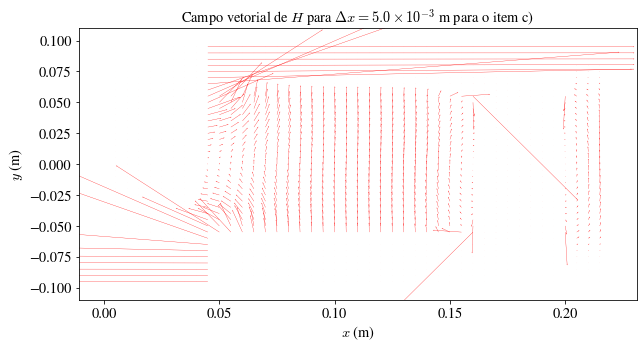

In [101]:
# Parâmetros
u0      = 4*np.pi*1e-7 #.. H/m
urFex   = 2500*u0 #....... H/m
urFey   = 2500*u0 #....... H/m
urAr    =    1*u0 #....... H/m
sBobina =     4e6 #... 1/Ohm.m
l       = .22 #............. m
h       = .20 #............. m
lbd     = 1.75 #     lambda, sobrerrelaxação
tol     = 1e-4 # tolerância, sobrerrelaxação
dx_list = [5e-3]
for dx in dx_list:
    M, N, X, Y, grid = gera_grid(dx, l, h)
    grid = define_elementos(X, Y, grid)
    mu = gera_mu(grid, urAr, urFex, urFey)
    A = sobrerrelaxa(dx, l, h)
    plot_surface(X, Y, A, 'b')
    Bx, By = calcula_B(A, N, M, dx, mu)
    Hx = calcula_H(Bx, mu[:, :, 0])
    Hy = calcula_H(By, mu[:, :, 1])
    plot_vectorial_field(X, Y, Bx, By, 'B', 'c')
    plot_vectorial_field(X, Y, Hx, Hy, 'H', 'c')
    Fela_x, Felay = calcula_F(Bx, By, grid)
    print(f'Item d), para {dx=}, {Fela_x=:.2f}, {Fela_y=:.2f}')
    #np.savetxt("b_0.0050.csv", A, delimiter=",")

dx=0.0025, Fx=2220.63, Fy=-10.04


<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

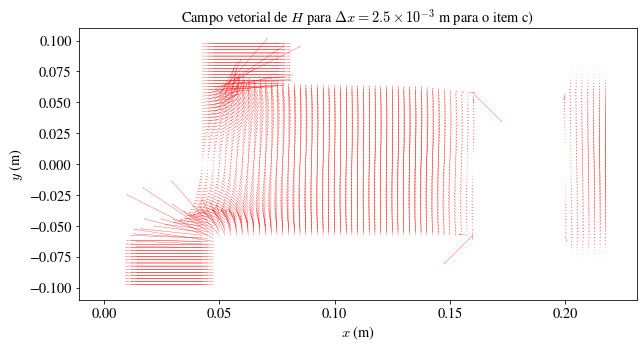

In [251]:
dx_list=['0.0025']
urFex = 2500*u0
for dx in dx_list:
    FILE = os.path.join(os.path.dirname(os.getcwd()), rf'A\b_{dx}.csv')
    Anew = np.genfromtxt(FILE, delimiter=',')
    dx = float(dx)
    
    M, N, X, Y, grid = gera_grid(dx, l, h)
    grid = define_elementos(X, Y, grid)
    mu = gera_mu(grid, urAr, urFex, urFey)
    plot_surface(X, Y, Anew, 'b')
    Bx, By = calcula_B(Anew, N, M, dx, mu)
    Hx = calcula_H(Bx, mu[:, :, 0])
    Hy = calcula_H(By, mu[:, :, 1])
    plot_vectorial_field(X, Y, Bx, By, 'B', 'c')
    plot_vectorial_field(X, Y, Hx, Hy, 'H', 'c')
    Fx, Fy = calcula_F(Bx, By, grid, dx)
    print(f'{dx=}, {Fx=:.2f}, {Fy=:.2f}')

In [61]:
# dx = 1e-3
# tol= 1e-4
# max_iter=1e5
# iterative_func=calcula_A
# M, N, X, Y, grid = gera_grid(dx, l, h)
# A    = inicializa_matriz_A(dx, l, h)
# grid = define_elementos(X, Y, grid)
# mu   = gera_mu(grid, urAr, urFex, urFey)

# uJ_parameters = {calcula_A:    {'mu':mu, 'X':X, 'Y': Y, 'grid': grid},
#                  calcula_A_e1: {'mu':mu, 'X':X, 'Y': Y, 'grid': grid,
#                                 'transiente':True, 'dt':1, 'k':1, 'omega':0}
#                 }[iterative_func]
# uJ   = gera_matriz_uJ(**uJ_parameters)
# Anew = iterative_func(A, dx, M, N, grid, uJ, mu)
# erro = np.max(np.abs(np.divide(Anew - A, Anew, out=np.zeros_like(Anew), where=Anew!=0)))
# i = 0
print("Iniciando sobrerrelaxação")
while erro > tol and i < max_iter:
    Anew, A = lbd*iterative_func(Anew, dx, M, N, grid, uJ, mu) + (1 - lbd)*A, Anew
    erro    = np.max(np.abs(np.divide(Anew - A, Anew, out=np.zeros_like(Anew), where=Anew!=0)))
    i+= 1
    if i%5e2== 0: 
        print(f"i={i}, erro={erro:.1e}")
print(f"i={i}, erro={erro:.1e}")
np.savetxt("AnewNovo.csv", Anew, delimiter=",")

Iniciando sobrerrelaxação
i=38000, erro=1.6e-03
i=38500, erro=7.1e-03
i=39000, erro=2.8e-03
i=39500, erro=2.3e-03
i=40000, erro=1.8e-02
i=40500, erro=1.8e-03
i=41000, erro=3.6e-03
i=41500, erro=4.5e-03
i=42000, erro=1.6e-03
i=42500, erro=6.8e-03
i=43000, erro=2.8e-03
i=43500, erro=1.8e-03
i=44000, erro=2.1e-02
i=44500, erro=2.2e-03
i=45000, erro=2.1e-03
i=45500, erro=4.9e-02
i=46000, erro=1.9e-03
i=46500, erro=2.3e-03
i=47000, erro=1.8e-02
i=47500, erro=1.8e-03
i=48000, erro=2.3e-03
i=48500, erro=1.7e-02
i=49000, erro=1.8e-03
i=49500, erro=2.1e-03
i=50000, erro=3.5e-02
i=50500, erro=1.9e-03
i=51000, erro=1.9e-03
i=51500, erro=3.1e-02
i=52000, erro=2.1e-03
i=52500, erro=1.6e-03
i=53000, erro=8.1e-03
i=53500, erro=2.6e-03
i=54000, erro=1.4e-03
i=54500, erro=4.1e-03
i=55000, erro=3.9e-03
i=55500, erro=1.3e-03
i=56000, erro=2.6e-03
i=56500, erro=9.0e-03
i=57000, erro=1.6e-03
i=57500, erro=1.8e-03
i=58000, erro=1.7e-02
i=58500, erro=2.2e-03
i=59000, erro=1.4e-03
i=59500, erro=4.1e-03
i=6000

In [59]:
np.savetxt("b_0.0010.csv", Anew, delimiter=",")

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

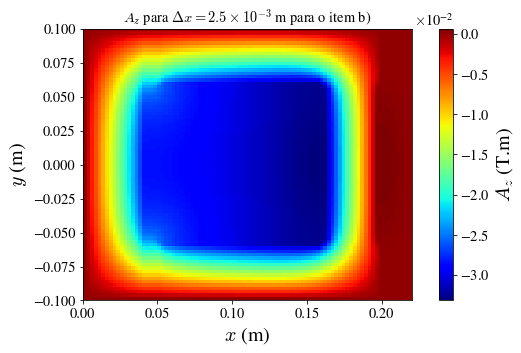

In [131]:
dx = 2.5e-3
M, N, X, Y, grid = gera_grid(dx, l, h)
grid = define_elementos(X, Y, grid)
mu = gera_mu(grid, urAr, urFex, urFey)
CSV_PATH = os.path.join(os.path.dirname(os.getcwd()), r'A\b_0.0025.csv')
Anew = np.genfromtxt(CSV_PATH, delimiter=',')
plot_surface(X, Y, Anew, 'b')
BxC, ByC = calcula_B(Anew, N, M, dx, mu)
# Hx = calcula_H(Bx, mu[:, :, 0])
# Hy = calcula_H(By, mu[:, :, 1])
# plot_vectorial_field(X, Y, Bx, By, 'B', 'c')
# plot_vectorial_field(X, Y, Hx, Hy, 'H', 'c')
# calcula_F(Bx, By, grid)

Iniciando sobrerrelaxação
i=5000, erro=6.7e-04
i=10000, erro=2.3e-04
i=12644, erro=1.0e-04


TypeError: calcula_F() missing 1 required positional argument: 'dx'

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

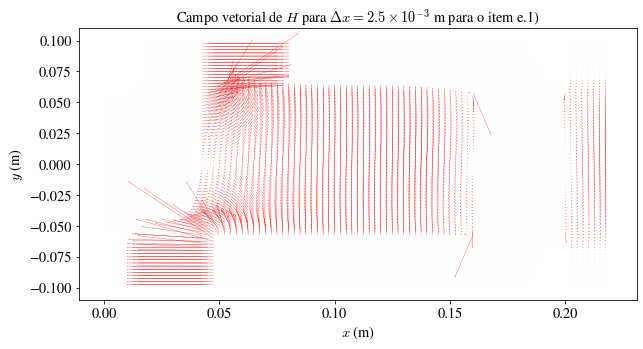

In [262]:
# item E
# E.1
# Novos parâmetros
dx = 2.5e-3
urFex = 1200*u0
              
M, N, X, Y, grid = gera_grid(dx, l, h)
grid = define_elementos(X, Y, grid)
mu = gera_mu(grid, urAr, urFex, urFey)
A = sobrerrelaxa(dx, l, h, iterative_func=calcula_A_e1)
plot_surface(X, Y, A, 'e.1')
Bx, By = calcula_B(A, N, M, dx, mu)
Hx = calcula_H(Bx, mu[:, :, 0])
Hy = calcula_H(By, mu[:, :, 1])
plot_vectorial_field(X, Y, Bx, By, 'B', 'e.1')
plot_vectorial_field(X, Y, Hx, Hy, 'H', 'e.1')
Fela_x, Fela_y = calcula_F(Bx, By, grid, dx)
print(f'Item e.1), para {dx=}, {Fela_x=:.2f}, {Fela_y=:.2f}')

# # E.2
# T = 501
# M, N, X, Y, grid = gera_grid(dx, l, h)
# A = inicializa_matriz_A(dx, l, h)
# grid = define_elementos(X, Y, grid)
# mu   = gera_mu(grid, urAr, urFex, urFey)
# dt = dx**2*urAr*sBobina/16
# alfa = sBobina*urAr**2*dx**2/(2*dt)
# Fela_x_vector = np.zeros(T)
# for k in range(T):
#     uJ = gera_matriz_uJ(mu, X, Y, grid, True, dt, k, omega=0)
#     A = calcula_A_transiente(A, dx, M, N, grid, uJ, mu)
#     Bx, By = calcula_B(A, N, M, dx, mu)
#     Hx = calcula_H(Bx, mu[:, :, 0])
#     Hy = calcula_H(By, mu[:, :, 1])
#     Fela_x, Fela_y = calcula_F(Bx, By, grid, dx)
#     Fela_x_vector[k] = Fela_x
#     if k in [10, 100, 500]:
#         plot_surface(X, Y, A, 'e.2', k)
#         plot_vectorial_field(X, Y, Bx, By, 'B', 'e.2', k)
#         plot_vectorial_field(X, Y, Hx, Hy, 'H', 'e.2', k)
        
# plot_electromagnetic_force(Fela_x_vector, T, dx)

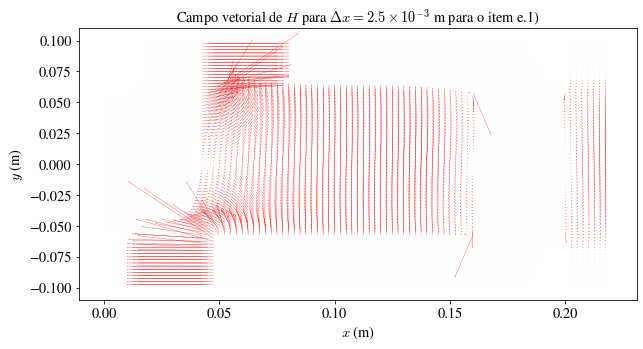

In [263]:
Bx, By = calcula_B(A, N, M, dx, mu)
Hx = calcula_H(Bx, mu[:, :, 0])
Hy = calcula_H(By, mu[:, :, 1])
plot_vectorial_field(X, Y, Bx, By, 'B', 'e.1')
plot_vectorial_field(X, Y, Hx, Hy, 'H', 'e.1')
Fela_x, Fela_y = calcula_F(Bx, By, grid, dx)

In [267]:
print(f'Item e.1), para {dx=}, {Fela_x=:.2f}, {Fela_y=:.2f}')

Item e.1), para dx=0.0025, Fela_x=-84.91, Fela_y=-10.06
